
作者：科技猛兽
链接：https://zhuanlan.zhihu.com/p/166632315
来源：知乎
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

有这样一个 `logits` 或者是 `distribution`, 我们对它采样得到一个index，我们需要这个过程是可导的。

我们知道一个离散随机变量X的分布，比如说p(X=1)=p1=0.2，p(X=2)=p2=0.3，p(X=3)=p2=0.5，然后我们想得到一些服从这个分布的离散的x的值。我们一般的思路当然是，就按照这个概率去采样，采样一些x来用就行了。但是这么做有一个问题：我们采样出来的x只有值，没有生成x的式子。本来x的值和p1,p2,p3是相关的，但是我们使用采样这么一个办法之后，我们得到的x没有办法对p1,p2,p3求导，这在神经网络里面就是一个大问题，没法BP了。

那么，能不能给一个以p1,p2,p3为参数的公式，让这个公式返回的结果是x的采样呢？这样的话，我们就可以对这个公式求导，从而得到采样的x对p1,p2,p3的导数了！

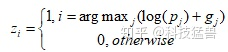



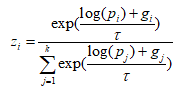

$\tau$ 越小，$z_i$ 越接近one-hot vector

In [9]:
# g_i, gumbel 噪声 
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

In [10]:
# z_i, 用softmax 代替 argmax
def gumbel_softmax_sample(logits, temperature=1):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

In [44]:
def gumbel_softmax(logits, temperature=1, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    
    # gumbel-softmax
    if not hard:
        return y

    # hard
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y  
    return y_hard

In [51]:
bs = 5
n_class = 100
logits = torch.randn(bs, n_class)

# argmax
print("argmax: ", logits.topk(5,  dim=-1))

argmax:  torch.return_types.topk(
values=tensor([[3.0391, 2.6974, 2.5481, 2.1835, 1.9891],
        [2.2437, 1.8880, 1.8251, 1.7873, 1.7017],
        [2.3548, 2.0256, 1.7797, 1.6955, 1.6863],
        [2.1947, 1.9972, 1.9843, 1.7432, 1.7242],
        [1.7659, 1.6835, 1.4928, 1.4561, 1.4218]]),
indices=tensor([[35, 36,  7,  1, 47],
        [68, 27, 98, 35, 43],
        [ 6, 81, 34, 76, 64],
        [88, 63, 17, 21,  6],
        [74, 33, 69, 84, 99]]))


In [52]:
### gumbel-softmax
y_hard = gumbel_softmax(logits, temperature=0.1, hard=False)
print(y_hard.topk(5))

torch.return_types.topk(
values=tensor([[9.9919e-01, 3.2820e-04, 3.1096e-04, 9.0332e-05, 7.2861e-05],
        [9.9787e-01, 2.1049e-03, 2.1102e-05, 1.9249e-11, 7.4327e-14],
        [9.9810e-01, 8.7187e-04, 6.4518e-04, 3.2919e-04, 4.3565e-05],
        [1.0000e+00, 7.4917e-08, 1.9510e-08, 1.4803e-08, 1.8091e-09],
        [9.9999e-01, 1.2698e-05, 3.2675e-07, 1.8019e-07, 2.5848e-10]]),
indices=tensor([[98, 90,  4, 78, 54],
        [82, 68, 42, 32, 41],
        [46, 17, 81, 48, 21],
        [27,  2, 85,  6, 47],
        [69, 20, 84, 90,  0]]))
